In [1]:
import deeplake
ds = deeplake.load("hub://activeloop/celeb-a-train")  # or val / test


/home/andreafabbricatore/gan_interpretability/ganexplainer/lib/python3.10/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-train



|

hub://activeloop/celeb-a-train loaded successfully.



/home/andreafabbricatore/gan_interpretability/ganexplainer/lib/python3.10/site-packages/deeplake/api/dataset.py:845: UserWarning: Dataset has more than 20 tensors. Skipping integrity check. Specify `check_integrity=True` to perform integrity check.
  warnings.warn(



# TEST

In [3]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

sample = ds[0]
# Assuming img is a NumPy array of shape (H, W, 3), dtype=uint8
img = sample['images'].numpy()

# Convert to PIL Image
pil_img = Image.fromarray(img)

# Resize to 256x256
resized = pil_img.resize((256, 256))


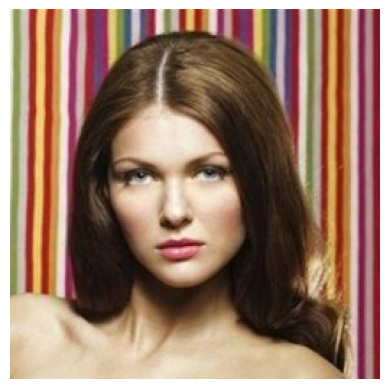

In [4]:
plt.imshow(resized)
plt.axis('off')
plt.show()


# GENERATE SAMPLES

In [5]:
import random

def get_balanced_samples(ds, attribute: str, n: int = 1000):
    """
    Returns a balanced list of indices for a binary attribute (e.g., smiling).
    n: total number of samples (should be even)
    """
    pos_idxs, neg_idxs = [], []

    print(f"Building balanced subset for attribute: {attribute}")

    for i in range(len(ds)):
        val = int(ds[i][attribute].numpy())

        if val == 1 and len(pos_idxs) < n // 2:
            pos_idxs.append(i)
        elif val == 0 and len(neg_idxs) < n // 2:
            neg_idxs.append(i)

        if len(pos_idxs) >= n // 2 and len(neg_idxs) >= n // 2:
            break

    print(f"Positive: {len(pos_idxs)}, Negative: {len(neg_idxs)}")
    return pos_idxs + neg_idxs


In [6]:
ATTRIBUTES = ['smiling', 'blond_hair', 'no_beard', 'eyeglasses', 'bald']

In [ ]:
import os
from torchvision.transforms import Resize
import pandas as pd
from tqdm import tqdm
# Build full list
all_records = []
img_dir = "celeba_samples"
os.makedirs(img_dir, exist_ok=True)
resize = Resize((256, 256))  # match e4e input

global_counter = 0
for attr in ATTRIBUTES:
    idxs = get_balanced_samples(ds, attr, n=1000)
    for i in tqdm(idxs):
        img_np = ds[i]['images'].numpy()
        img = Image.fromarray(img_np).resize((256, 256))
        fname = f"{global_counter:05d}.jpg"
        img.save(os.path.join(img_dir, fname))

        # Collect labels for all attributes
        record = {"filename": fname}
        for a in ATTRIBUTES:
            record[a] = int(ds[i][a].numpy())
        all_records.append(record)
        global_counter += 1

df = pd.DataFrame(all_records)
df.to_csv("celeba_samples_labels.csv", index=False)

NameError: name 'ATTRIBUTES' is not defined

In [9]:
df.head()

,filename,smiling,blond_hair,no_beard,eyeglasses,bald
0,00000.jpg,1,0,0,0,0
1,00001.jpg,1,0,1,0,0
2,00002.jpg,1,0,0,0,0
3,00003.jpg,1,0,0,0,0
4,00004.jpg,1,0,1,0,0


In [10]:
df.to_csv("celeba_samples_labels.csv", index=False)

In [1]:
import pandas as pd

df = pd.read_csv("celeba_samples_labels.csv")

In [23]:
balanced_dfs = {}

for attr in ['smiling', 'bald', 'blond_hair', 'eyeglasses', 'beard']:
    df_balanced = pd.concat([
        df[df[attr] == 1].sample(n=500, random_state=42),
        df[df[attr] == 0].sample(n=500, random_state=42)
    ]).reset_index(drop=True)

    balanced_dfs[attr] = df_balanced
    print(f"{attr}: balanced to {df_balanced[attr].value_counts().to_dict()}")


smiling: balanced to {1: 500, 0: 500}
bald: balanced to {1: 500, 0: 500}
blond_hair: balanced to {1: 500, 0: 500}
eyeglasses: balanced to {1: 500, 0: 500}
beard: balanced to {1: 500, 0: 500}


In [27]:
import os
ATTRIBUTES = ['smiling', 'blond_hair', 'beard', 'eyeglasses', 'bald']
for i in ATTRIBUTES:
    balanced_dfs[i].to_csv(f"{i}_df.csv", index=False)

    import shutil

    os.makedirs(f"celeba_{i}", exist_ok=True)

    for filename in balanced_dfs[i]['filename']:
        shutil.copy(f"celeba_samples/{filename}", f"celeba_{i}/{filename}")
